In [5]:
import requests
import pandas as pd
import zipfile
import urllib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
import cudf
%load_ext autoreload
%autoreload
%load_ext cudf.pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
date_range = pd.date_range(start='2023-01-01', end='2023-01-01')
csv_paths = [Path(f'data/AIS_{date.strftime("%Y_%m_%d")}.csv') for date in date_range]
daily_ais_dfs = [pd.read_csv(csv_path) for csv_path in csv_paths]
df = pd.concat(daily_ais_dfs)

### Assign Vessel Groups

In [7]:
vessel_groups = {}
vessel_groups["Cargo"] = np.concatenate([np.arange(70, 80), [1003, 1004, 1016]])
vessel_groups["Fishing"] = np.array([30, 1001, 1002])
vessel_groups["Military"] = np.array([35])
vessel_groups["Not Available"] = np.array([0])
vessel_groups["Other"] = np.concatenate([np.arange(1, 21), np.arange(23, 30), np.arange(33, 35), np.arange(38, 52), np.arange(53, 60), np.arange(90, 1000), np.arange(1005, 1012), [1018, 1020, 1022]])
vessel_groups["Passenger"] = np.concatenate([np.arange(60, 70), np.arange(1012, 1016)])
vessel_groups["Pleasure Craft"] = np.array([36, 37, 1019])
vessel_groups["Tanker"] = np.concatenate([np.arange(80, 90), [1017, 1024]])
vessel_groups["Tug Tow"] = np.array([21, 22, 31, 32, 52, 1023, 1025])


map_to_vessel_group = dict()
for vg in vessel_groups:
    for i in vessel_groups[vg]:
        map_to_vessel_group[int(i)] = vg
vessel_group_to_id = dict()
for i, v in enumerate(set(map_to_vessel_group.values())):
    vessel_group_to_id[v] = i
    
    
df["Vessel Group"] = df["VesselType"].map(map_to_vessel_group)

In [8]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,Vessel Group
0,368926035,2023-01-01T00:00:05,38.65165,-90.17964,0.1,360.0,511.0,KIMMSWICK,NaN,AENA,33.0,15.0,NaN,NaN,NaN,33.0,A,Other
1,367647050,2023-01-01T00:00:04,30.16506,-90.99936,6.3,161.4,511.0,USS CAIRO,NaN,WDH7325,31.0,0.0,20.0,NaN,NaN,31.0,A,Tug Tow
2,352001704,2023-01-01T00:00:04,28.91963,-94.37033,14.7,97.5,97.0,ENEOS EXPLORER,IMO9935492,3E2723,80.0,0.0,230.0,36.0,11.7,80.0,A,Tanker
3,367104060,2023-01-01T00:00:00,34.33537,-119.56046,14.8,202.9,511.0,ALAN T,IMO8982577,WDC9571,60.0,15.0,28.0,7.0,NaN,0.0,A,Passenger
4,367099730,2023-01-01T00:00:02,26.53889,-97.40485,0.0,360.0,511.0,JESSIE M,NaN,WDJ2892,52.0,0.0,0.0,0.0,0.0,52.0,A,Tug Tow


### Positional Heatmaps

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


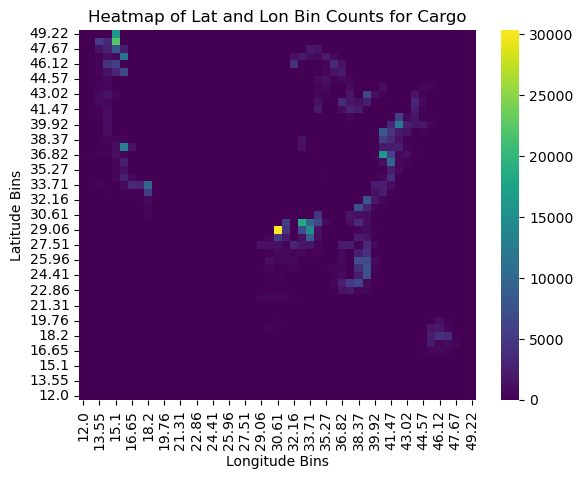

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


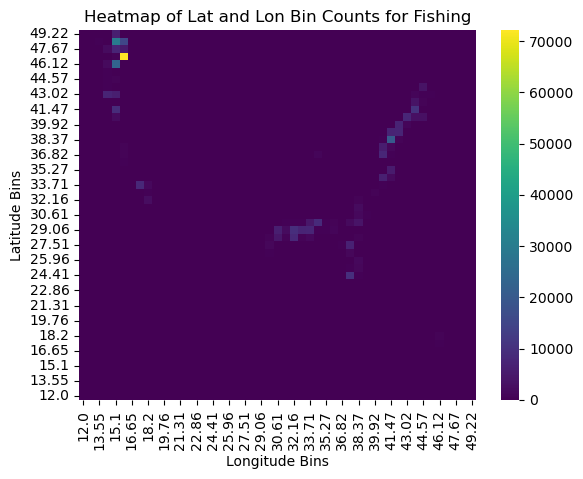

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


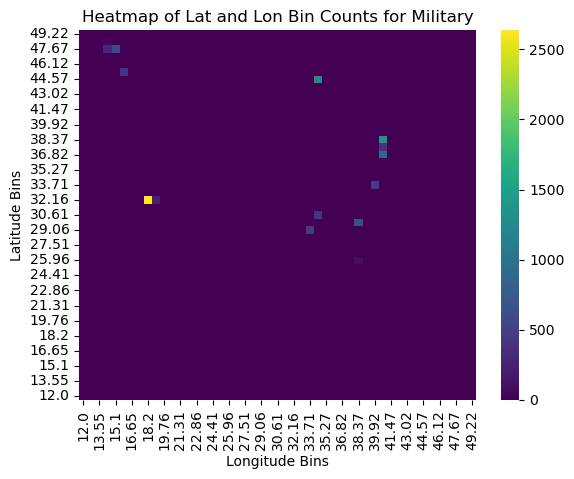

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


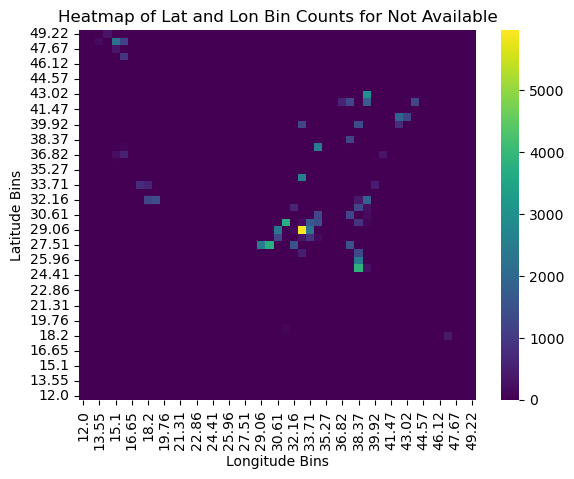

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


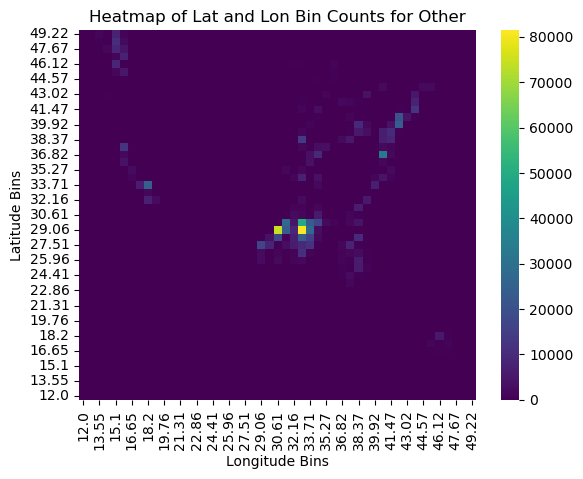

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


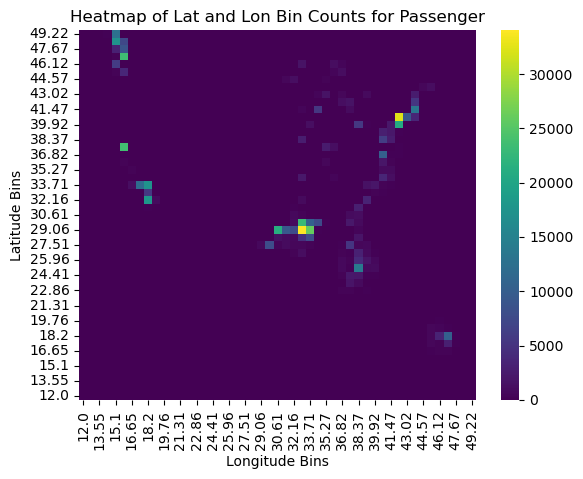

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


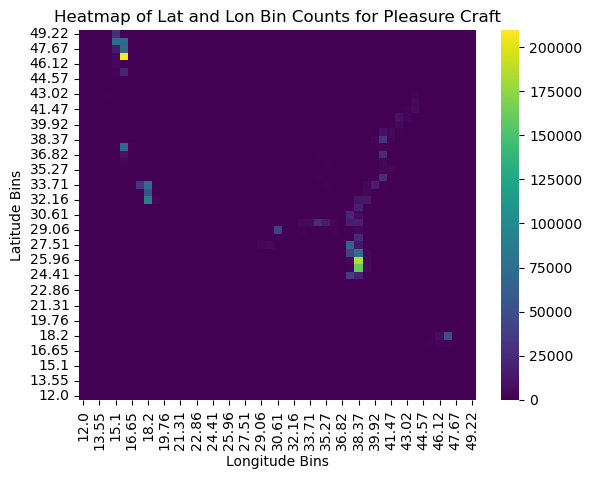

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


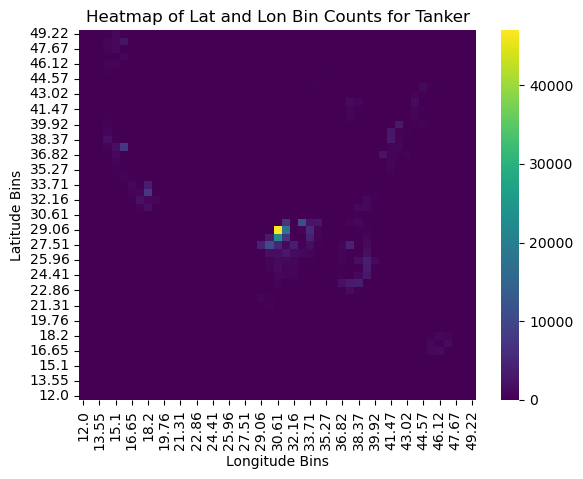

/tmp/ipykernel_322183/3784792255.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)


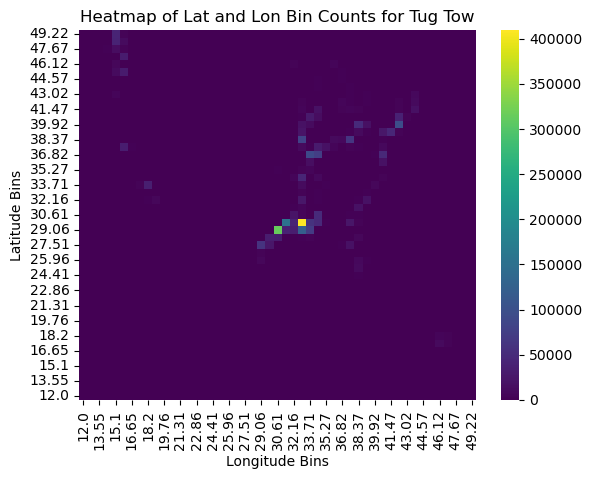

In [16]:
LON_min = -130
LON_max = -60
LAT_min = 12
LAT_max = 50

LAT_bins = np.linspace(LAT_min, LAT_max, 50)
LON_bins = np.linspace(LON_min, LON_max, 50)

df["LAT_bin"] = pd.cut(df["LAT"], bins=LAT_bins, labels=np.round(LAT_bins[:-1],decimals=2))
df["LON_bin"] = pd.cut(df["LON"], bins=LON_bins, labels=np.round(LAT_bins[:-1],decimals=2))

# Create a pivot table to aggregate the counts of lat and lon bins
# heatmap_data = df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)
# heatmap_data = heatmap_data.iloc[::-1]
# # Create the heatmap
# sns.heatmap(heatmap_data, cmap='viridis')

# Set the axis labels and title
plt.xlabel('Longitude Bins')
plt.ylabel('Latitude Bins')
plt.title('Heatmap of Lat and Lon Bin Counts')

for vessel in vessel_groups:
    vessel_df = df[df["Vessel Group"] == vessel]
    heatmap_data = vessel_df.pivot_table(index='LAT_bin', columns='LON_bin', aggfunc='size', fill_value=0)
    heatmap_data = heatmap_data.iloc[::-1]
    # Create the heatmap
    sns.heatmap(heatmap_data, cmap='viridis')

    # Set the axis labels and title
    plt.xlabel('Longitude Bins')
    plt.ylabel('Latitude Bins')
    plt.title(f'Heatmap of Lat and Lon Bin Counts for {vessel}')
    plt.show()  
# Show the heatmap
plt.show()

### Timestep Distribution

In [101]:
unique_MMSIs = df['MMSI'].unique()
dt = [] # Store the time deltas

# Iterate through uids (MMSI) to compute time deltas
# for MMSI in unique_MMSIs:
#     MMSI_df = df[df['MMSI'] == MMSI]
df.sort_values(by=['BaseDateTime'], inplace=True)
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'])
df['TimeDelta'] = df.groupby('MMSI')['BaseDateTime'].diff()

In [102]:
df.tail()
df[df['MMSI']==367357320]

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,TimeDelta
7579,367357320,2023-01-01 00:00:09,30.80223,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,NaT
10048,367357320,2023-01-01 00:01:20,30.80223,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:11
16641,367357320,2023-01-01 00:02:28,30.80222,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:08
25369,367357320,2023-01-01 00:03:39,30.80221,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:11
64153,367357320,2023-01-01 00:04:59,30.80221,-81.51778,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8144212,367357320,2023-01-01 23:55:19,30.80221,-81.51777,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:10
7418498,367357320,2023-01-01 23:56:28,30.80222,-81.51777,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:09
7418470,367357320,2023-01-01 23:57:40,30.80222,-81.51779,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:12
8146923,367357320,2023-01-01 23:58:50,30.80222,-81.51780,0.0,360.0,511.0,C-TRACTOR 3,IMO8835164,WBX3589,70.0,0.0,29.0,11.0,3.3,31.0,A,0 days 00:01:10


In [103]:
df['TimeDelta'].dt.total_seconds().max()

np.float64(85041.0)

(1, 2000)

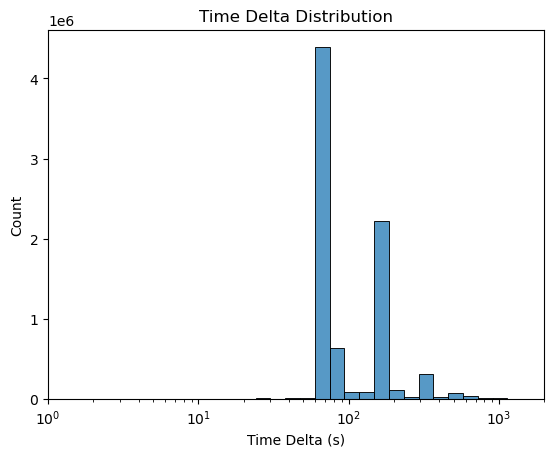

In [104]:
ax = sns.histplot(df['TimeDelta'].dt.total_seconds(), bins=50, log_scale=True)
ax.set(xlabel='Time Delta (s)', ylabel='Count', title='Time Delta Distribution')
ax.set_xlim(1, 2000)

### Positional Heatmaps based on Vessel Type

In [29]:

# sns.histplot(data=df, x='LON', y='LAT', cmap='viridis')
# plt.title('LAT vs LON Heatmap')
# plt.show()

df['VesselType'].unique()


### Distribution of Vessel Types

MMSI: 100%|██████████| 15932/15932 [03:04<00:00, 86.24it/s]


Text(0.5, 0, 'Count')

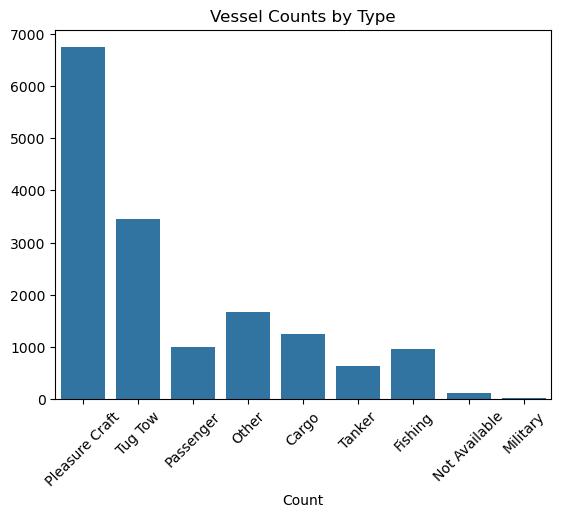

In [108]:

vessel_groups_counts = {}

# Assign vessel groups to each MMSI



unique_MMSIs = df['MMSI'].unique()
for MMSI in tqdm(unique_MMSIs, desc='MMSI'):
     MMSI_df = df[df['MMSI'] == MMSI]
     vessel_type = MMSI_df.iloc[0]['VesselType']

     for vessel_group in vessel_groups:
          if vessel_type in vessel_groups[vessel_group]:
               df.loc[df['MMSI'] == MMSI,'VesselGroup'] = vessel_group # update the DataFrame with the vessel group
               if vessel_group in vessel_groups_counts:
                    vessel_groups_counts[vessel_group] += 1
               else:
                    vessel_groups_counts[vessel_group] = 1

sns.barplot(vessel_groups_counts)
plt.title("Vessel Counts by Type")
plt.xticks(rotation=45)
plt.xlabel('Count')

In [90]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,TimeDelta,VesselGroup
2351,366876420,2023-01-01,32.72374,-117.22354,0.0,18.7,511.0,AFTERGLOW,NaN,WDI5149,37.0,NaN,33.0,8.0,NaN,NaN,B,NaT,Pleasure Craft
682,366989380,2023-01-01,38.06354,-122.26807,36.2,248.4,248.0,MARE ISLAND,IMO9144665,WDC2198,60.0,0.0,43.0,12.0,1.5,60.0,A,NaT,Passenger
7346,367486370,2023-01-01,33.74594,-118.22476,0.0,218.2,8.0,NRC QUEST,IMO9271195,WDF7619,90.0,0.0,48.0,10.0,3.0,70.0,A,NaT,Other
673,368122350,2023-01-01,21.28582,-157.86644,5.6,275.4,511.0,TIGER22-,NaN,WDL3512,99.0,0.0,0.0,0.0,0.0,99.0,A,NaT,Other
3425,368045410,2023-01-01,27.84012,-97.06920,0.0,140.5,511.0,JOSEPH F WEBER,IMO1012865430,WDK3453,60.0,15.0,46.0,16.0,3.3,60.0,A,NaT,Passenger


### SOG v.s. Vessel Type

Unique Vessel Types: 66


<Axes: xlabel='SOG', ylabel='VesselGroup'>

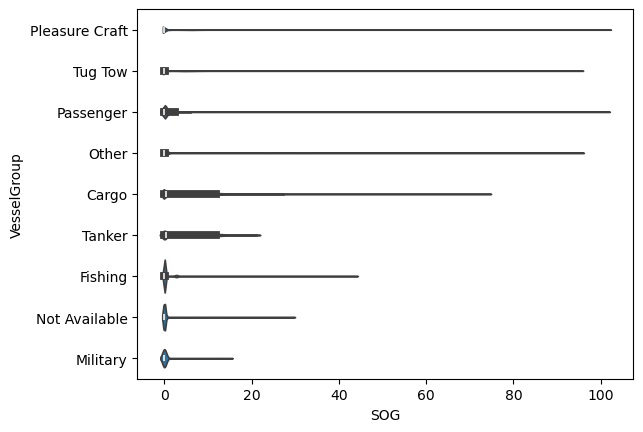

In [113]:
# Remove sentinel SOG values
# 102.3: Not available
# 102.2: 102.2 knots or higher
df_SOG = df[(df['SOG'] != 102.3) & (df['SOG'] != 102.2)]
unique_vessel_types = df_SOG['VesselType'].unique()
unique_vessel_types.sort()
print(f'Unique Vessel Types: {len(unique_vessel_types)}')

max_SOG_by_vessel_type = {}

df_SOG.tail()
sns.violinplot(data=df_SOG, x="SOG", y="VesselGroup")

# sns.boxplot(data=df_SOG, x="SOG", y="VesselGroup", whis=(0,100))
